<a href="https://colab.research.google.com/github/toledotorrespatricio/hjb-nn-mmcc/blob/main/model_dim_18_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:106: SyntaxWarning: invalid escape sequence '\ '
<>:106: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1319557994.py:106: SyntaxWarning: invalid escape sequence '\ '
  """[CTRL] Construye el conjunto Ω_N = {|m*νψ ± n*νχ| : m,n=0..N} \ {0}"""


CONFIGURACIÓN DEL SISTEMA
Orden armónico N=3, generando 24 frecuencias
Paso temporal h=0.000111s, κ=60, f_max=150.0Hz
Parámetros eléctricos: C=0.002F, L=0.001H, R=0.5Ω
Amplitudes RMS: A_ψ=270.0V, A_χ=311.0V
Límites: v_C∈[0.5,1.5], i_s∈[-20.0,20.0]
Θ_max=10.0, lr=0.01, épocas_max=200
[CTRL] Frecuencias armónicas (14): [ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 150.]

[OPT] Iniciando optimización...
[OPT] Época   0: loss=1144869.125000, z=1144869.125000, g_max=1909.420166, ||∇||=3115498.500000, ||θ||=1.859
[OPT] Época  20: loss=300624.406250, z=300624.406250, g_max=1629.715210, ||∇||=264794.968750, ||θ||=2.414
[OPT] Época  40: loss=245624.671875, z=245624.671875, g_max=1644.412109, ||∇||=97194.890625, ||θ||=2.482
[OPT] Época  60: loss=221224.328125, z=221224.328125, g_max=1626.982910, ||∇||=222800.234375, ||θ||=2.456
[OPT] Época  80: loss=211221.671875, z=211221.687500, g_max=1630.389526, ||∇||=84230.882812, ||θ||=2.421
[OPT] Época 100: loss=203878.906250, z=203878

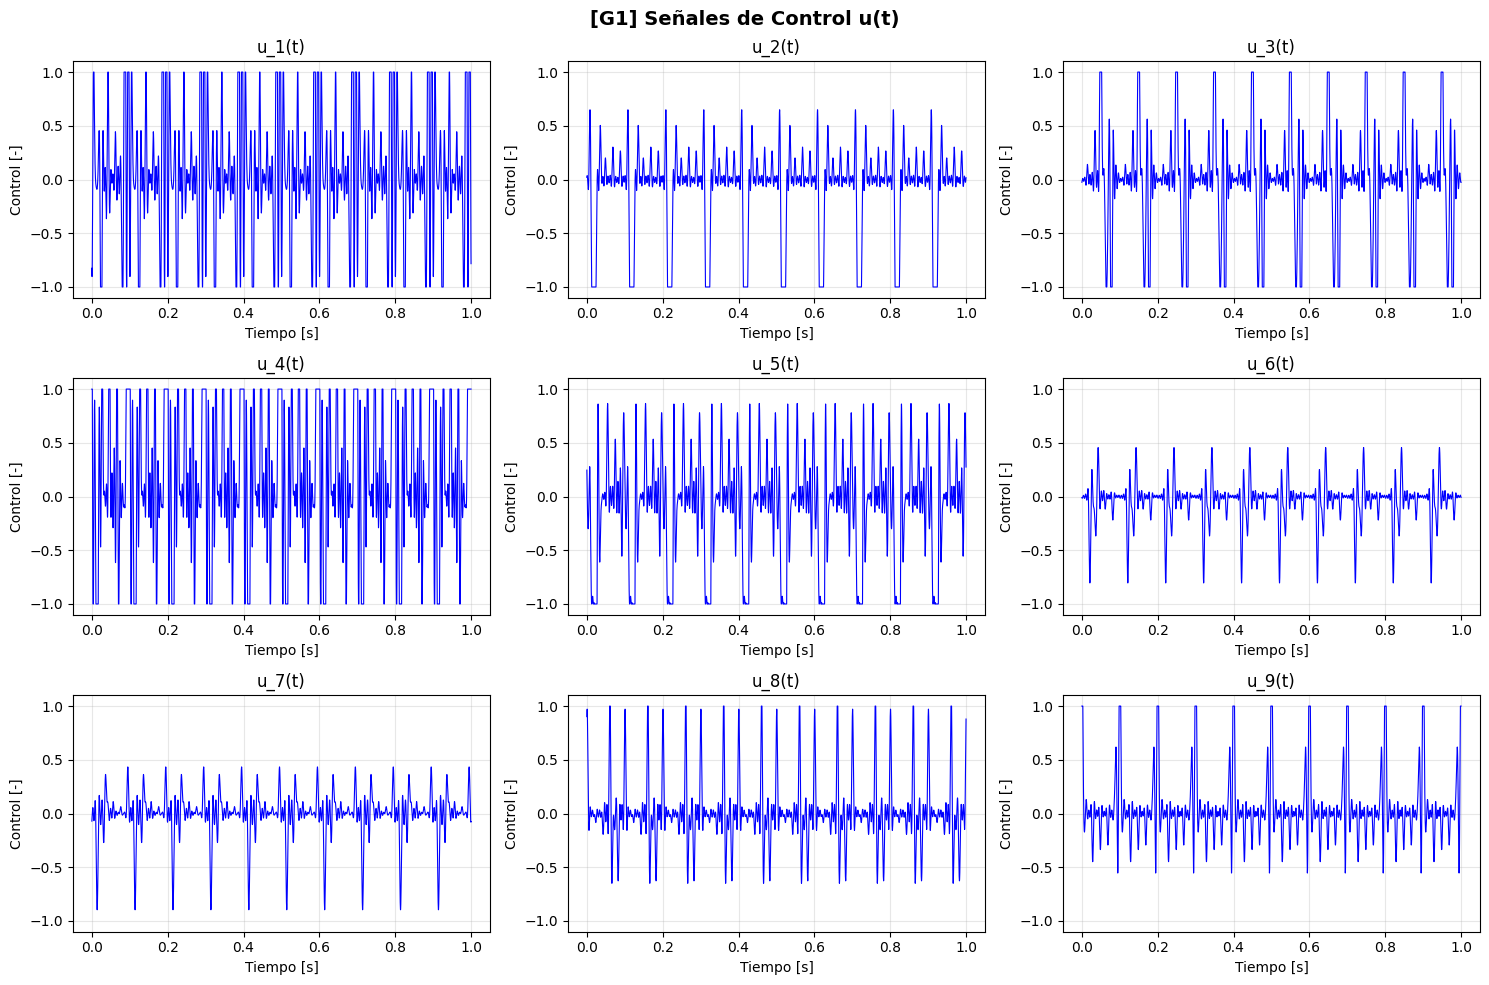

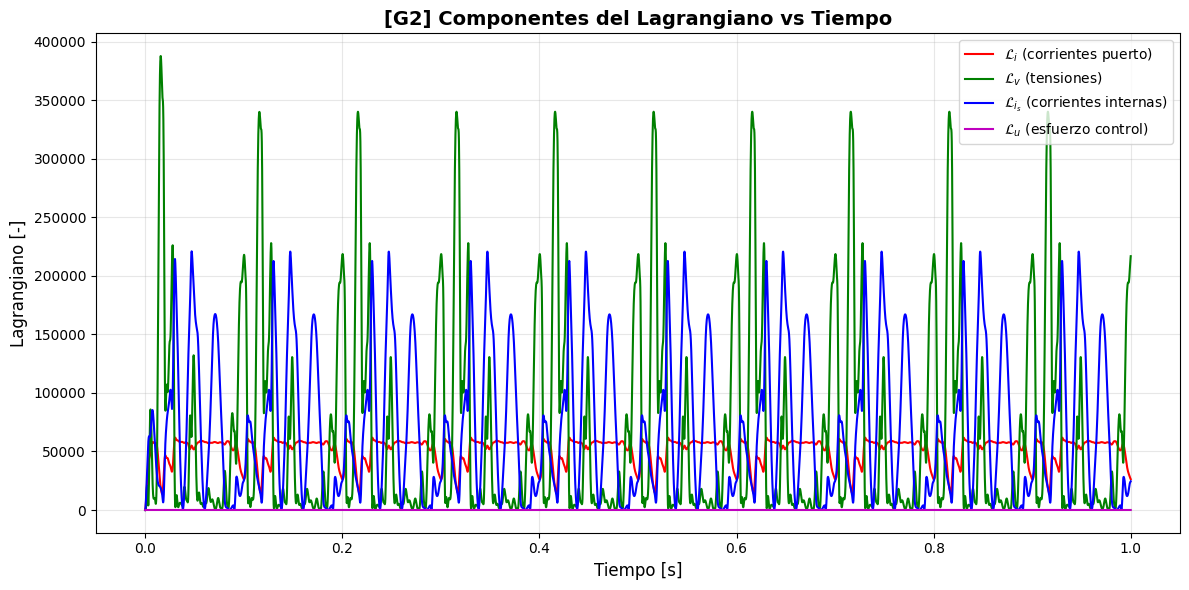

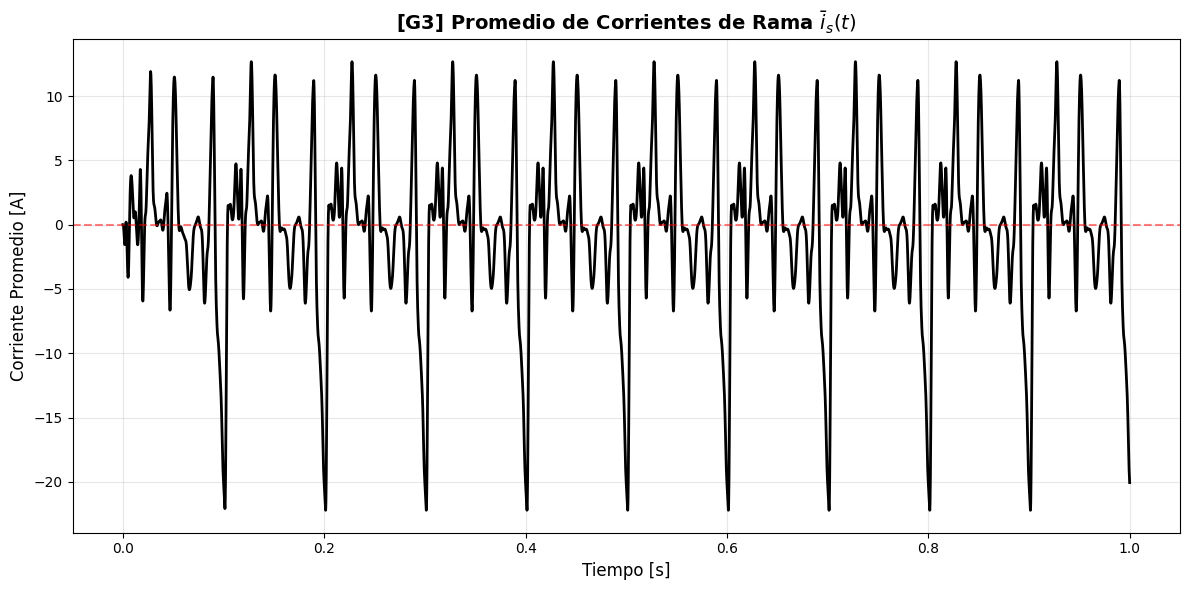

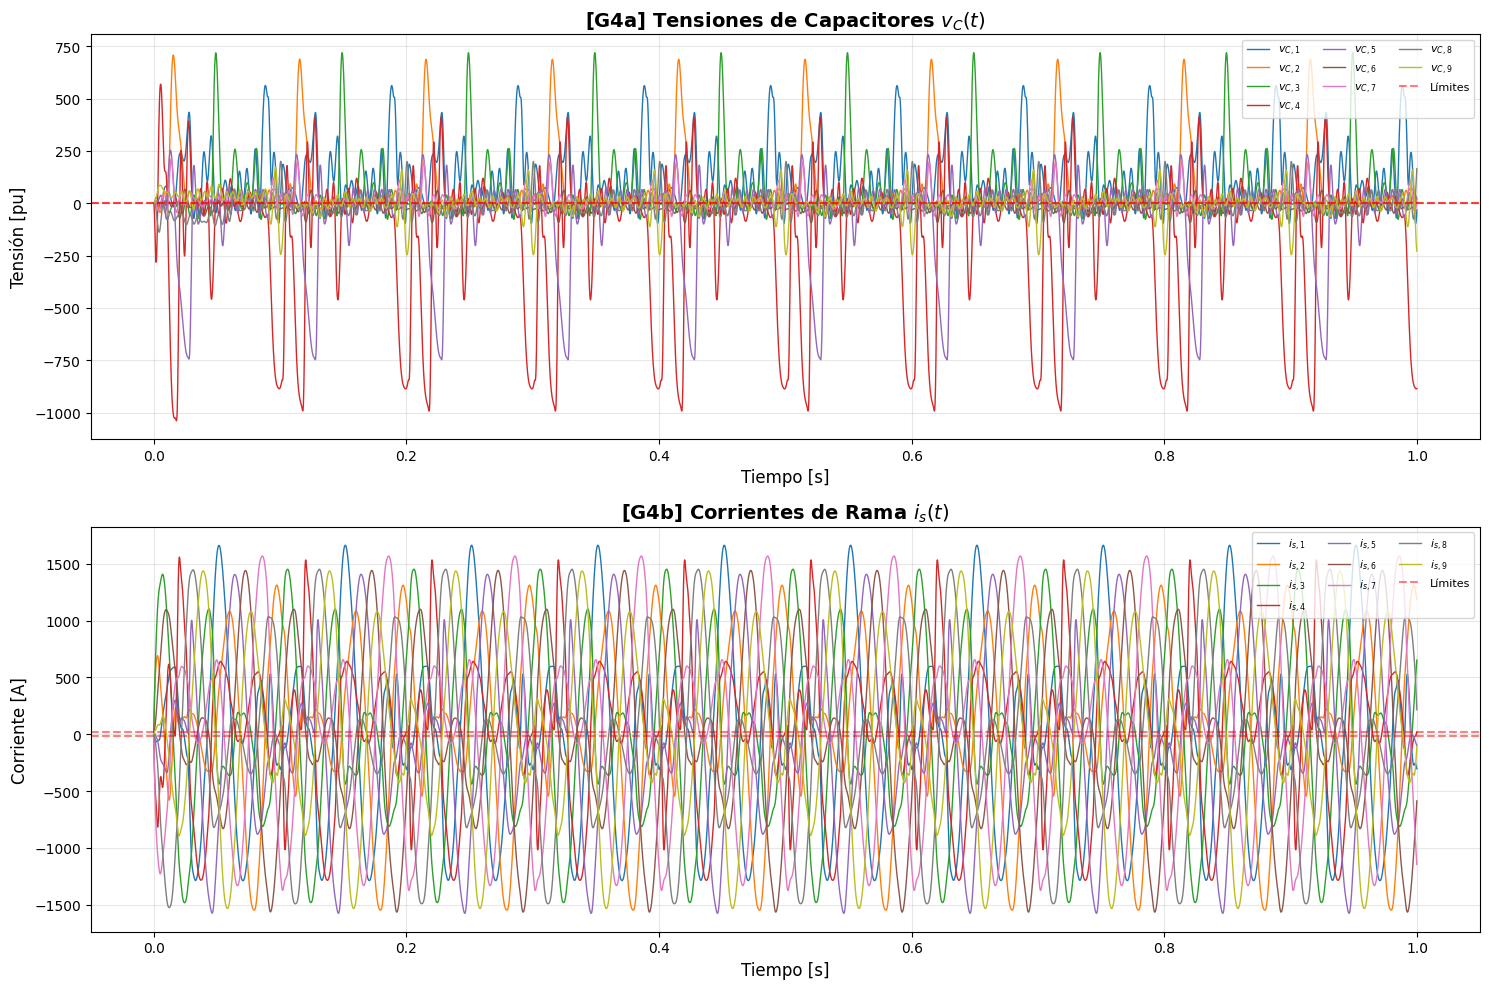

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# [OPT] Configuración determinista con semillas fijas para reproducibilidad
torch.manual_seed(42)  # [OPT] Semilla fija para PyTorch asegura resultados reproducibles
np.random.seed(42)    # [OPT] Semilla fija para NumPy asegura inicialización consistente

# ===================== PARÁMETROS DEL SISTEMA =====================

# [REF] Parámetros de referencias trifásicas (señales externas con asterisco)
T = 1.0           # [REF] Tiempo de simulación en segundos
nu_psi = 20.0     # [REF] Frecuencia del puerto ψ en Hz
nu_chi = 30.0     # [REF] Frecuencia del puerto χ en Hz
phi_psi = 0.0     # [REF] Fase inicial del puerto ψ en radianes
phi_chi = 0.0     # [REF] Fase inicial del puerto χ en radianes
A_psi = 270.0     # [REF] Amplitud RMS trifásica del puerto ψ en V
A_chi = 311.0     # [REF] Amplitud RMS trifásica del puerto χ en V

# [DYN] Parámetros eléctricos del convertidor (capacitancia, inductancia, resistencia)
C = 2e-3          # [DYN] Capacitancia de cada celda en Faradios
L = 1e-3          # [DYN] Inductancia de cada rama en Henrios
R = 0.5           # [DYN] Resistencia de cada rama en Ohms

# [CTRL] Límites del control (señales de conmutación normalizadas)
u_min = -1.0      # [CTRL] Valor mínimo del control (conmutación negativa)
u_max = 1.0       # [CTRL] Valor máximo del control (conmutación positiva)

# [OBST] Límites de estado para restricciones de seguridad
v_C_min = 0.5     # [OBST] Tensión mínima en capacitores en pu
v_C_max = 1.5     # [OBST] Tensión máxima en capacitores en pu
i_s_min = -20.0   # [OBST] Corriente mínima en ramas en A
i_s_max = 20.0    # [OBST] Corriente máxima en ramas en A

# [LAGR] Pesos del Lagrangiano (suma = 1 para normalización)
lambda_i = 0.35   # [LAGR] Peso para error de corrientes de puerto
lambda_v = 0.25   # [LAGR] Peso para error de tensiones de capacitor
lambda_is = 0.20  # [LAGR] Peso para componentes internas de corriente
lambda_u = 0.20   # [LAGR] Peso para esfuerzo de control

# [LAGR] Factores de normalización para cada componente del costo
E_i_N = 10.0      # [LAGR] Normalización para error de corrientes de puerto
E_v_N = 1.0       # [LAGR] Normalización para error de tensiones
E_is_N = 5.0      # [LAGR] Normalización para corrientes internas
E_u_N = 100.0     # [LAGR] Normalización para esfuerzo de control

# [CTRL] Parámetros del control armónico
N = 3             # [CTRL] Orden máximo de armónicos (m,n = 0..N)
Theta_max = 10.0  # [CTRL] Norma L2 máxima de coeficientes θ

# [INT] Parámetros de integración numérica
kappa = 60        # [INT] Factor de sobremuestreo para paso temporal
f_max = N * (nu_psi + nu_chi)  # [INT] Frecuencia máxima en el sistema = 3*(20+30) = 150 Hz
h = 1.0 / (kappa * f_max)      # [INT] Paso de integración = 1/(60*150) ≈ 0.00011 s
K_steps = int(T / h)           # [INT] Número total de pasos = 1/0.00011 ≈ 9000

# [OPT] Parámetros de optimización
lr = 0.01         # [OPT] Tasa de aprendizaje para Adam
max_epochs = 200  # [OPT] Número máximo de épocas
grad_clip = 1.0   # [OPT] Valor máximo para clipping de gradientes
tol = 1e-4        # [OPT] Tolerancia para convergencia
tau_smooth = 0.1  # [OPT] Parámetro de suavizado para soft-max

print("="*60)
print("CONFIGURACIÓN DEL SISTEMA")
print("="*60)
print(f"Orden armónico N={N}, generando {2*N*(N+1)} frecuencias")
print(f"Paso temporal h={h:.6f}s, κ={kappa}, f_max={f_max:.1f}Hz")
print(f"Parámetros eléctricos: C={C:.3f}F, L={L:.3f}H, R={R:.1f}Ω")
print(f"Amplitudes RMS: A_ψ={A_psi}V, A_χ={A_chi}V")
print(f"Límites: v_C∈[{v_C_min},{v_C_max}], i_s∈[{i_s_min},{i_s_max}]")
print(f"Θ_max={Theta_max}, lr={lr}, épocas_max={max_epochs}")
print("="*60)

# ===================== MATRICES DEL SISTEMA =====================

# [DYN] Matriz A: mapea corrientes de rama (9D) a corrientes de puerto (6D)
# Estructura: primeras 3 filas = puerto ψ, últimas 3 = puerto χ
A = torch.tensor([
    [1, 1, 1, 0, 0, 0, 0, 0, 0],  # [DYN] Suma corrientes ramas 1-3 → fase a de ψ
    [0, 0, 0, 1, 1, 1, 0, 0, 0],  # [DYN] Suma corrientes ramas 4-6 → fase b de ψ
    [0, 0, 0, 0, 0, 0, 1, 1, 1],  # [DYN] Suma corrientes ramas 7-9 → fase c de ψ
    [-1, 0, 0, -1, 0, 0, -1, 0, 0],  # [DYN] Extrae corrientes índices 1,4,7 → fase a de χ
    [0, -1, 0, 0, -1, 0, 0, -1, 0],  # [DYN] Extrae corrientes índices 2,5,8 → fase b de χ
    [0, 0, -1, 0, 0, -1, 0, 0, -1]   # [DYN] Extrae corrientes índices 3,6,9 → fase c de χ
], dtype=torch.float32)

# [DYN] Matriz K: acoplamientos entre celdas, K = (8I - 11^T)/9
ones = torch.ones(9, 1)  # [DYN] Vector de unos para construcción de K
K = (8 * torch.eye(9) - ones @ ones.T) / 9  # [DYN] K promedia y resta componente común

# [DYN] Pseudo-inversa de A para proyección: A† = (A^T A)^{-1} A^T
A_pinv = torch.pinverse(A)  # [DYN] A† mapea corrientes de puerto (6D) → ramas (9D)

# [DYN] Proyector al núcleo de A: P_ker = I - A†A
P_ker = torch.eye(9) - A_pinv @ A  # [DYN] Proyecta al espacio de corrientes internas

# ===================== CONSTRUCCIÓN DEL CONTROL ARMÓNICO =====================

def build_harmonic_frequencies(N: int, nu_psi: float, nu_chi: float) -> torch.Tensor:
    """[CTRL] Construye el conjunto Ω_N = {|m*νψ ± n*νχ| : m,n=0..N} \ {0}"""
    freqs = set()  # [CTRL] Conjunto para evitar frecuencias duplicadas
    for m in range(N + 1):  # [CTRL] Iteración sobre armónicos de ψ
        for n in range(N + 1):  # [CTRL] Iteración sobre armónicos de χ
            f1 = abs(m * nu_psi + n * nu_chi)  # [CTRL] Frecuencia suma |mνψ + nνχ|
            f2 = abs(m * nu_psi - n * nu_chi)  # [CTRL] Frecuencia diferencia |mνψ - nνχ|
            if f1 > 0:  # [CTRL] Excluir frecuencia cero
                freqs.add(f1)  # [CTRL] Agregar frecuencia suma no-nula
            if f2 > 0:  # [CTRL] Excluir frecuencia cero
                freqs.add(f2)  # [CTRL] Agregar frecuencia diferencia no-nula
    return torch.tensor(sorted(freqs), dtype=torch.float32)  # [CTRL] Vector ordenado de frecuencias

# [CTRL] Generar conjunto de frecuencias armónicas
omega_N = build_harmonic_frequencies(N, nu_psi, nu_chi)  # [CTRL] Ω_N para el control
n_freqs = len(omega_N)  # [CTRL] Número de frecuencias únicas
print(f"[CTRL] Frecuencias armónicas ({n_freqs}): {omega_N.numpy()}")

# ===================== PARAMETRIZACIÓN DEL CONTROL =====================

class HarmonicControl(nn.Module):
    """[CTRL] Control armónico u_j(t) = u_{j,0} + Σ_ω (a_{j,ω}cos(2πωt) + b_{j,ω}sin(2πωt))"""

    def __init__(self, omega_N: torch.Tensor):
        super().__init__()
        self.omega_N = omega_N  # [CTRL] Frecuencias del ansatz armónico
        n_freqs = len(omega_N)  # [CTRL] Número de frecuencias

        # [CTRL] Parámetros θ = [u_0(9), a(9×n_freqs), b(9×n_freqs)]
        self.u0 = nn.Parameter(torch.zeros(9))  # [CTRL] Componente DC para cada celda
        self.a_coeff = nn.Parameter(torch.randn(9, n_freqs) * 0.1)  # [CTRL] Coeficientes coseno
        self.b_coeff = nn.Parameter(torch.randn(9, n_freqs) * 0.1)  # [CTRL] Coeficientes seno

        # [CTRL] Inicialización con fundamentales dominantes
        with torch.no_grad():
            # [CTRL] Buscar índices de frecuencias fundamentales νψ y νχ
            idx_psi = torch.argmin(torch.abs(omega_N - nu_psi))  # [CTRL] Índice de νψ
            idx_chi = torch.argmin(torch.abs(omega_N - nu_chi))  # [CTRL] Índice de νχ
            self.a_coeff[:, idx_psi] = 0.3  # [CTRL] Inicializar coseno de νψ
            self.a_coeff[:, idx_chi] = 0.2  # [CTRL] Inicializar coseno de νχ

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """[CTRL] Evalúa u_θ(t) para tiempo(s) t"""
        if t.dim() == 0:  # [CTRL] Si t es escalar, convertir a tensor 1D
            t = t.unsqueeze(0)  # [CTRL] Agregar dimensión para broadcasting

        batch_size = t.shape[0]  # [CTRL] Número de puntos temporales
        u = self.u0.unsqueeze(0).expand(batch_size, -1)  # [CTRL] DC: expandir u_0 a batch×9

        # [CTRL] Calcular fase 2πωt para cada frecuencia y tiempo
        phases = 2 * np.pi * t.unsqueeze(1) * self.omega_N.unsqueeze(0)  # [CTRL] batch×n_freqs

        # [CTRL] Sumar componentes armónicas: Σ_ω (a_ω cos(2πωt) + b_ω sin(2πωt))
        cos_terms = torch.cos(phases)  # [CTRL] cos(2πωt) para cada ω y t
        sin_terms = torch.sin(phases)  # [CTRL] sin(2πωt) para cada ω y t

        # [CTRL] u += Σ_ω a_{j,ω} cos(2πωt): producto matricial batch×n_freqs @ n_freqs×9
        u = u + (cos_terms @ self.a_coeff.T)  # [CTRL] Suma ponderada de cosenos
        # [CTRL] u += Σ_ω b_{j,ω} sin(2πωt): producto matricial batch×n_freqs @ n_freqs×9
        u = u + (sin_terms @ self.b_coeff.T)  # [CTRL] Suma ponderada de senos

        # [CTRL] Aplicar saturación (clipping) al rango [u_min, u_max]
        u = torch.clamp(u, u_min, u_max)  # [CTRL] Limitar señales de control

        return u.squeeze() if batch_size == 1 else u  # [CTRL] Quitar dimensión si entrada escalar

    def project_theta(self, theta_max: float):
        """[OPT] Proyecta coeficientes θ al balón ||θ||₂ ≤ Θ_max"""
        with torch.no_grad():
            # [OPT] Concatenar todos los parámetros en vector θ
            theta = torch.cat([  # [OPT] θ = [u_0; vec(a); vec(b)]
                self.u0.flatten(),       # [OPT] Componentes DC (9 valores)
                self.a_coeff.flatten(),  # [OPT] Coeficientes coseno (9×n_freqs valores)
                self.b_coeff.flatten()   # [OPT] Coeficientes seno (9×n_freqs valores)
            ])

            # [OPT] Calcular norma L2 de θ
            theta_norm = torch.norm(theta)  # [OPT] ||θ||₂ = sqrt(Σθᵢ²)

            # [OPT] Si ||θ||₂ > Θ_max, escalar θ → θ * (Θ_max/||θ||₂)
            if theta_norm > theta_max:
                scale = theta_max / theta_norm  # [OPT] Factor de escalamiento < 1
                self.u0.mul_(scale)         # [OPT] Escalar componentes DC
                self.a_coeff.mul_(scale)    # [OPT] Escalar coeficientes coseno
                self.b_coeff.mul_(scale)    # [OPT] Escalar coeficientes seno

# ===================== REFERENCIAS TRIFÁSICAS =====================

def compute_references(t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """[REF] Calcula referencias trifásicas v*_ψχ(t) e i*_ψχ(t)"""

    # [REF] Convertir amplitudes RMS a pico: V_pico = V_RMS * sqrt(2)
    A_psi_peak = A_psi * np.sqrt(2)  # [REF] Amplitud pico puerto ψ
    A_chi_peak = A_chi * np.sqrt(2)  # [REF] Amplitud pico puerto χ

    # [REF] Fases trifásicas: [0°, -120°, +120°]
    phase_shifts = torch.tensor([0, -2*np.pi/3, 2*np.pi/3])  # [REF] Desfases trifásicos

    # [REF] v*_ψ(t) = A_ψ [cos(2πν_ψt+φ_ψ), cos(2πν_ψt+φ_ψ-120°), cos(2πν_ψt+φ_ψ+120°)]^T
    phase_psi = 2 * np.pi * nu_psi * t + phi_psi  # [REF] Fase base puerto ψ
    v_psi_star = A_psi_peak * torch.cos(phase_psi + phase_shifts)  # [REF] Tensiones ψ (3×1)

    # [REF] v*_χ(t) = A_χ [cos(2πν_χt+φ_χ), cos(2πν_χt+φ_χ-120°), cos(2πν_χt+φ_χ+120°)]^T
    phase_chi = 2 * np.pi * nu_chi * t + phi_chi  # [REF] Fase base puerto χ
    v_chi_star = A_chi_peak * torch.cos(phase_chi + phase_shifts)  # [REF] Tensiones χ (3×1)

    # [REF] Concatenar v*_ψχ = [v*_ψ; v*_χ] ∈ ℝ⁶
    v_star = torch.cat([v_psi_star, v_chi_star])  # [REF] Vector 6D de tensiones

    # [REF] Para corrientes, usar mismas formas de onda pero con amplitudes ajustadas
    # [REF] Balance de potencia: P_ψ = P_χ → A_ψ*I_ψ = A_χ*I_χ → I_ψ/I_χ = A_χ/A_ψ
    I_psi_peak = 10.0  # [REF] Corriente pico puerto ψ en A
    I_chi_peak = I_psi_peak * A_psi / A_chi  # [REF] Corriente pico puerto χ para balance

    # [REF] i*_ψ(t) con misma fase que v*_ψ (factor de potencia unitario)
    i_psi_star = I_psi_peak * torch.cos(phase_psi + phase_shifts)  # [REF] Corrientes ψ (3×1)

    # [REF] i*_χ(t) con misma fase que v*_χ (factor de potencia unitario)
    i_chi_star = I_chi_peak * torch.cos(phase_chi + phase_shifts)  # [REF] Corrientes χ (3×1)

    # [REF] Concatenar i*_ψχ = [i*_ψ; i*_χ] ∈ ℝ⁶
    i_star = torch.cat([i_psi_star, i_chi_star])  # [REF] Vector 6D de corrientes

    return v_star, i_star  # [REF] Retornar referencias de tensión y corriente

# ===================== DINÁMICA DEL SISTEMA =====================

def system_dynamics(x: torch.Tensor, u: torch.Tensor, t: float) -> torch.Tensor:
    """[DYN] Calcula ẋ = f(t,x,u) con x=(v_C, i_s)∈ℝ¹⁸"""

    # [DYN] Descomponer estado x = [v_C(9); i_s(9)]
    v_C = x[:9]  # [DYN] Tensiones de capacitores (primeros 9 componentes)
    i_s = x[9:]  # [DYN] Corrientes de rama (últimos 9 componentes)

    # [REF] Obtener referencias externas en tiempo t
    v_star, _ = compute_references(torch.tensor(t))  # [REF] v*_ψχ(t) ∈ ℝ⁶

    # [DYN] Ecuación de capacitores: ẋ_C = C⁻¹ diag(i_s) u
    # diag(i_s) @ u realiza producto elemento a elemento i_s ⊙ u
    dv_C_dt = (1.0 / C) * (i_s * u)  # [DYN] C⁻¹ escala tasa de cambio de tensión

    # [DYN] Ecuación de inductancias: ẋ_s = L⁻¹[-R i_s + A^T v*_ψχ - K diag(v_C) u]

    # [DYN] Término resistivo: -R i_s representa pérdidas óhmicas
    resistive_term = -R * i_s  # [DYN] Caída de tensión por resistencia

    # [DYN] Término de fuente: A^T v*_ψχ mapea tensiones de puerto (6D) a ramas (9D)
    source_term = A.T @ v_star  # [DYN] A^T proyecta referencias de puerto a espacio de ramas

    # [DYN] Término de acoplamiento: K diag(v_C) u implementa interacción entre celdas
    # diag(v_C) @ u = v_C ⊙ u es producto elemento a elemento
    # K @ (v_C ⊙ u) aplica matriz de acoplamiento/promediado
    coupling_term = K @ (v_C * u)  # [DYN] K promedia y resta componente común

    # [DYN] Suma de términos escalada por L⁻¹
    di_s_dt = (1.0 / L) * (resistive_term + source_term - coupling_term)  # [DYN] L⁻¹ escala respuesta inductiva

    # [DYN] Concatenar derivadas ẋ = [ẋ_C; ẋ_s]
    dx_dt = torch.cat([dv_C_dt, di_s_dt])  # [DYN] Vector 18D de derivadas

    return dx_dt  # [DYN] Retornar derivada del estado completo

# ===================== INTEGRADOR RK4 =====================

def rk4_step(f, x: torch.Tensor, u: torch.Tensor, h: float, t: float) -> torch.Tensor:
    """[INT] Paso de Runge-Kutta 4to orden: integra ẋ=f(t,x,u) desde t hasta t+h"""

    # [INT] RK4 evalúa la derivada en 4 puntos y promedia con pesos [1,2,2,1]/6

    # [INT] k₁ = f(t, x, u): derivada en punto inicial
    k1 = f(x, u, t)  # [INT] Pendiente al inicio del intervalo

    # [INT] k₂ = f(t+h/2, x+h*k₁/2, u): derivada en punto medio usando k₁
    # x + h*k₁/2 es estimación de x(t+h/2) por Euler con paso h/2
    k2 = f(x + 0.5 * h * k1, u, t + 0.5 * h)  # [INT] Pendiente en punto medio (método 1)

    # [INT] k₃ = f(t+h/2, x+h*k₂/2, u): derivada en punto medio usando k₂
    # x + h*k₂/2 es estimación mejorada de x(t+h/2) usando k₂
    k3 = f(x + 0.5 * h * k2, u, t + 0.5 * h)  # [INT] Pendiente en punto medio (método 2)

    # [INT] k₄ = f(t+h, x+h*k₃, u): derivada en punto final usando k₃
    # x + h*k₃ es estimación de x(t+h) por Euler con pendiente k₃
    k4 = f(x + h * k3, u, t + h)  # [INT] Pendiente al final del intervalo

    # [INT] Combinación convexa: x(t+h) = x(t) + h*(k₁ + 2k₂ + 2k₃ + k₄)/6
    # Promedio ponderado da más peso a evaluaciones en punto medio (error O(h⁵))
    x_next = x + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)  # [INT] Actualización RK4

    return x_next  # [INT] Retornar estado en t+h

# ===================== CÁLCULO DE RESIDUOS Y LAGRANGIANO =====================

def compute_residuals(x: torch.Tensor, u: torch.Tensor, t: float) -> Dict[str, torch.Tensor]:
    """[LAGR] Calcula todos los residuos e_i, e_v, e_{i_s}, e_u para el Lagrangiano"""

    # [LAGR] Descomponer estado
    v_C = x[:9]  # [LAGR] Tensiones de capacitores
    i_s = x[9:]  # [LAGR] Corrientes de rama

    # [REF] Obtener referencias
    v_star, i_star = compute_references(torch.tensor(t))  # [REF] v*_ψχ, i*_ψχ

    # [LAGR] e_i = A i_s - i*_ψχ: error de corrientes de puerto
    # A @ i_s mapea corrientes de rama (9D) a puerto (6D)
    e_i = A @ i_s - i_star  # [LAGR] Diferencia entre corrientes reales y deseadas en puertos

    # [LAGR] e_v = v_C - v*_C: error de tensiones (v*_C = 1.0 por defecto)
    v_C_star = torch.ones(9)  # [LAGR] Referencia unitaria para tensiones de capacitor
    e_v = v_C - v_C_star  # [LAGR] Desviación de tensiones respecto a referencia

    # [LAGR] e_{i_s} = (I - A†A) i_s: componente en núcleo de A
    # P_ker @ i_s proyecta al espacio de corrientes internas (circulantes)
    e_is = P_ker @ i_s  # [LAGR] Corrientes que no contribuyen a puertos (internas)

    # [LAGR] e_u = A^T v*_ψχ - diag(v_C) u: residuo de esfuerzo de control
    # A^T @ v_star mapea tensiones de puerto a ramas
    # v_C * u es producto elemento a elemento (tensión × control)
    e_u = (A.T @ v_star) - (v_C * u)  # [LAGR] Diferencia entre tensión deseada y aplicada

    return {'e_i': e_i, 'e_v': e_v, 'e_is': e_is, 'e_u': e_u}  # [LAGR] Diccionario de residuos

def compute_lagrangian_components(residuals: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    """[LAGR] Calcula componentes individuales del Lagrangiano L = Σ λ_k ||e_k||²/E_k²"""

    # [LAGR] L_i = λ_i ||e_i||² / E_{i,N}²: costo de error de corrientes de puerto
    L_i = lambda_i * torch.norm(residuals['e_i'])**2 / E_i_N**2  # [LAGR] Normalizado por E_i_N²

    # [LAGR] L_v = λ_v ||e_v||² / E_{v,N}²: costo de error de tensiones
    L_v = lambda_v * torch.norm(residuals['e_v'])**2 / E_v_N**2  # [LAGR] Normalizado por E_v_N²

    # [LAGR] L_{is} = λ_{is} ||e_{is}||² / E_{is,N}²: costo de corrientes internas
    L_is = lambda_is * torch.norm(residuals['e_is'])**2 / E_is_N**2  # [LAGR] Normalizado por E_is_N²

    # [LAGR] L_u = λ_u ||e_u||² / E_{u,N}²: costo de esfuerzo de control
    L_u = lambda_u * torch.norm(residuals['e_u'])**2 / E_u_N**2  # [LAGR] Normalizado por E_u_N²

    return {'L_i': L_i, 'L_v': L_v, 'L_is': L_is, 'L_u': L_u}  # [LAGR] Componentes del Lagrangiano

# ===================== FUNCIÓN OBSTÁCULO =====================

def obstacle_function(x: torch.Tensor) -> torch.Tensor:
    """[OBST] Calcula g(x) ≤ 0 si x ∈ X (todas las cotas se cumplen)"""

    # [OBST] Descomponer estado
    v_C = x[:9]  # [OBST] Tensiones de capacitores
    i_s = x[9:]  # [OBST] Corrientes de rama

    # [OBST] Violaciones de cota inferior: max(0, límite_inf - variable)
    v_C_lower_viol = torch.relu(v_C_min - v_C)  # [OBST] Violación v_C < v_C_min
    v_C_upper_viol = torch.relu(v_C - v_C_max)  # [OBST] Violación v_C > v_C_max
    i_s_lower_viol = torch.relu(i_s_min - i_s)  # [OBST] Violación i_s < i_s_min
    i_s_upper_viol = torch.relu(i_s - i_s_max)  # [OBST] Violación i_s > i_s_max

    # [OBST] Máxima violación por componente (peor caso en cada dimensión)
    max_viol = torch.max(torch.cat([  # [OBST] Concatenar todas las violaciones
        v_C_lower_viol,  # [OBST] Violaciones cota inferior v_C
        v_C_upper_viol,  # [OBST] Violaciones cota superior v_C
        i_s_lower_viol,  # [OBST] Violaciones cota inferior i_s
        i_s_upper_viol   # [OBST] Violaciones cota superior i_s
    ]))

    return max_viol  # [OBST] g(x) = máxima violación (≤0 si factible)

def smooth_max(a: torch.Tensor, b: torch.Tensor, tau: float = 0.1) -> torch.Tensor:
    """[OPT] Soft-max suave: log-sum-exp para máximo diferenciable"""
    # [OPT] smooth_max(a,b,τ) = τ·log(exp(a/τ) + exp(b/τ))
    # Aproxima max(a,b) pero es diferenciable (necesario para backprop)
    return tau * torch.logsumexp(torch.stack([a/tau, b/tau]), dim=0)  # [OPT] LSE suavizado

# ===================== SIMULACIÓN FORWARD =====================

def simulate_system(control: HarmonicControl, x0: torch.Tensor,
                    return_trajectory: bool = True) -> Dict[str, torch.Tensor]:
    """[INT] Integra el sistema completo y calcula métricas"""

    # [INT] Inicialización
    x = x0.clone()  # [INT] Estado inicial (clonar para no modificar original)

    # [INT] Almacenamiento de trayectorias si se solicita
    if return_trajectory:
        x_traj = [x0.clone()]  # [INT] Lista para guardar estados
        u_traj = []           # [INT] Lista para guardar controles
        L_components = {'L_i': [], 'L_v': [], 'L_is': [], 'L_u': []}  # [LAGR] Componentes

    # [COST] Inicializar acumuladores
    z_total = torch.tensor(0.0, requires_grad=True)  # [COST] Costo integral total
    g_max = torch.tensor(-float('inf'))  # [OBST] Máxima violación de restricciones

    # [INT] Bucle de integración temporal
    for k in range(K_steps):
        t_k = k * h  # [INT] Tiempo actual t_k = k·h

        # [CTRL] Evaluar control en tiempo t_k
        u_k = control(torch.tensor(t_k))  # [CTRL] u_θ(t_k) con clipping interno

        # [LAGR] Calcular residuos y componentes del Lagrangiano
        residuals = compute_residuals(x, u_k, t_k)  # [LAGR] e_i, e_v, e_is, e_u
        L_comps = compute_lagrangian_components(residuals)  # [LAGR] L_i, L_v, L_is, L_u

        # [COST] Acumular costo integral: z += L(t_k)·h
        L_k = sum(L_comps.values())  # [LAGR] L = L_i + L_v + L_is + L_u
        z_total = z_total + L_k * h  # [COST] Integración por rectángulos

        # [OBST] Actualizar máxima violación con smooth-max
        g_k = obstacle_function(x)  # [OBST] g(x_k) para estado actual
        g_max = smooth_max(g_max, g_k, tau_smooth)  # [OBST] Máximo suave temporal

        # [INT] Avanzar estado con RK4
        x = rk4_step(system_dynamics, x, u_k, h, t_k)  # [INT] x_{k+1} = RK4(x_k, u_k)

        # [INT] Guardar trayectoria si se solicita
        if return_trajectory:
            x_traj.append(x.clone())  # [INT] Guardar estado
            u_traj.append(u_k.clone())  # [INT] Guardar control
            for key in L_components:
                L_components[key].append(L_comps[key].clone())  # [LAGR] Guardar componentes

    # [INT] Preparar salida
    results = {
        'z_total': z_total,  # [COST] Costo integral total
        'g_max': g_max,      # [OBST] Máxima violación
    }

    if return_trajectory:
        results['x_traj'] = torch.stack(x_traj)  # [INT] Matriz de estados (K+1)×18
        results['u_traj'] = torch.stack(u_traj)  # [INT] Matriz de controles K×9
        results['L_components'] = {k: torch.stack(v) for k, v in L_components.items()}  # [LAGR]

    return results

# ===================== OPTIMIZACIÓN =====================

# [OPT] Crear controlador con parámetros iniciales
control = HarmonicControl(omega_N)  # [OPT] Instanciar control armónico

# [OPT] Estado inicial: tensiones nominales, corrientes cero
x0 = torch.cat([  # [OPT] x₀ = [v_C(0); i_s(0)]
    torch.ones(9),   # [OPT] v_C(0) = 1.0 pu (nominal)
    torch.zeros(9)   # [OPT] i_s(0) = 0 A (reposo)
])

# [OPT] Configurar optimizador Adam
optimizer = torch.optim.Adam(control.parameters(), lr=lr)  # [OPT] Adam con lr=0.01

# [OPT] Almacenar historial de optimización
loss_history = []  # [OPT] Lista para guardar pérdidas
grad_norm_history = []  # [OPT] Lista para normas de gradiente

print("\n[OPT] Iniciando optimización...")
print("="*60)

# [OPT] Bucle principal de optimización
for epoch in range(max_epochs):
    # [OPT] Forward pass: simular sistema
    results = simulate_system(control, x0, return_trajectory=False)  # [OPT] Solo métricas

    # [OPT] Calcular pérdida total
    # loss = max(g_max, z_total) usando smooth-max
    loss = smooth_max(results['g_max'], results['z_total'], tau_smooth)  # [OPT] Pérdida principal

    # [OPT] Penalización por norma de θ excesiva
    theta_cat = torch.cat([  # [OPT] Concatenar todos los parámetros
        control.u0.flatten(),
        control.a_coeff.flatten(),
        control.b_coeff.flatten()
    ])
    theta_norm = torch.norm(theta_cat)  # [OPT] ||θ||₂
    theta_penalty = torch.relu(theta_norm - Theta_max)**2  # [OPT] Penalidad cuadrática

    # [OPT] Pérdida total con penalizaciones
    total_loss = loss + 0.1 * theta_penalty  # [OPT] loss + β_θ·penalidad

    # [OPT] Backward pass
    optimizer.zero_grad()  # [OPT] Limpiar gradientes anteriores
    total_loss.backward()  # [OPT] Calcular gradientes por backpropagation

    # [OPT] Calcular norma del gradiente para monitoreo
    grad_norm = 0.0
    for param in control.parameters():
        if param.grad is not None:
            grad_norm += param.grad.norm()**2  # [OPT] Sumar normas cuadradas
    grad_norm = grad_norm**0.5  # [OPT] Norma L2 total del gradiente

    # [OPT] Gradient clipping para estabilidad
    torch.nn.utils.clip_grad_norm_(control.parameters(), grad_clip)  # [OPT] Limitar gradientes

    # [OPT] Actualizar parámetros
    optimizer.step()  # [OPT] Paso de Adam: θ ← θ - lr·∇L

    # [OPT] Proyectar θ al balón ||θ||₂ ≤ Θ_max
    control.project_theta(Theta_max)  # [OPT] Proyección después de actualización

    # [OPT] Guardar historial
    loss_history.append(total_loss.item())  # [OPT] Pérdida escalar
    grad_norm_history.append(grad_norm)  # [OPT] Norma de gradiente

    # [OPT] Imprimir progreso cada 20 épocas
    if epoch % 20 == 0:
        print(f"[OPT] Época {epoch:3d}: loss={total_loss.item():.6f}, "
              f"z={results['z_total'].item():.6f}, g_max={results['g_max'].item():.6f}, "
              f"||∇||={grad_norm:.6f}, ||θ||={theta_norm.item():.3f}")

    # [OPT] Criterio de convergencia: norma de gradiente pequeña
    if grad_norm < tol:
        print(f"[OPT] Convergencia alcanzada en época {epoch} (||∇|| < {tol})")
        break

print("="*60)
print("[OPT] Optimización completada\n")

# ===================== EVALUACIÓN FINAL =====================

print("Evaluando solución óptima...")

# [OPT] Simulación final con trayectoria completa
with torch.no_grad():  # [OPT] Sin cálculo de gradientes para evaluación
    final_results = simulate_system(control, x0, return_trajectory=True)

# [COST] Extraer resultados
x_traj = final_results['x_traj'].numpy()  # [INT] Trayectoria de estados
u_traj = final_results['u_traj'].numpy()  # [CTRL] Trayectoria de control
L_components = {k: v.numpy() for k, v in final_results['L_components'].items()}  # [LAGR]

# [COST] Calcular integrales de componentes
integral_L_i = np.trapz(L_components['L_i'], dx=h)  # [COST] ∫L_i dt
integral_L_v = np.trapz(L_components['L_v'], dx=h)  # [COST] ∫L_v dt
integral_L_is = np.trapz(L_components['L_is'], dx=h)  # [COST] ∫L_is dt
integral_L_u = np.trapz(L_components['L_u'], dx=h)  # [COST] ∫L_u dt
J_total = integral_L_i + integral_L_v + integral_L_is + integral_L_u  # [COST] J = Σ∫L_k

# [OBST] Calcular violaciones máximas
v_C_traj = x_traj[:, :9]  # [OBST] Tensiones a lo largo del tiempo
i_s_traj = x_traj[:, 9:]  # [OBST] Corrientes a lo largo del tiempo

v_C_min_viol = np.min(v_C_traj) - v_C_min  # [OBST] Máxima violación inferior v_C
v_C_max_viol = np.max(v_C_traj) - v_C_max  # [OBST] Máxima violación superior v_C
i_s_min_viol = np.min(i_s_traj) - i_s_min  # [OBST] Máxima violación inferior i_s
i_s_max_viol = np.max(i_s_traj) - i_s_max  # [OBST] Máxima violación superior i_s

# ===================== TABLA DE RESULTADOS =====================

print("\n" + "="*60)
print("TABLA DE INTEGRALES DE COSTO")
print("="*60)
print(f"∫L_i dt   = {integral_L_i:.6f}  (Error corrientes puerto)")
print(f"∫L_v dt   = {integral_L_v:.6f}  (Error tensiones capacitor)")
print(f"∫L_is dt  = {integral_L_is:.6f}  (Corrientes internas)")
print(f"∫L_u dt   = {integral_L_u:.6f}  (Esfuerzo de control)")
print("-"*60)
print(f"J total   = {J_total:.6f}")
print("="*60)

print("\n" + "="*60)
print("VALIDACIÓN DE RESTRICCIONES")
print("="*60)
print(f"v_C ∈ [{np.min(v_C_traj):.3f}, {np.max(v_C_traj):.3f}] (límites: [{v_C_min}, {v_C_max}])")
print(f"i_s ∈ [{np.min(i_s_traj):.3f}, {np.max(i_s_traj):.3f}] (límites: [{i_s_min}, {i_s_max}])")
print(f"Violación v_C_min: {max(0, -v_C_min_viol):.6f}")
print(f"Violación v_C_max: {max(0, v_C_max_viol):.6f}")
print(f"Violación i_s_min: {max(0, -i_s_min_viol):.6f}")
print(f"Violación i_s_max: {max(0, i_s_max_viol):.6f}")
print("="*60)

# ===================== GRÁFICOS =====================

# [PLOT] Configuración general de matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# [PLOT] Vector de tiempo para gráficos
t_plot = np.arange(K_steps) * h  # [PLOT] Malla temporal [0, T]

# [PLOT] G1: Control u(t) - 9 subplots
fig1, axes1 = plt.subplots(3, 3, figsize=(15, 10))  # [PLOT] Grid 3×3 para 9 celdas
fig1.suptitle('[G1] Señales de Control u(t)', fontsize=14, fontweight='bold')
for j in range(9):
    ax = axes1[j//3, j%3]  # [PLOT] Seleccionar subplot
    ax.plot(t_plot, u_traj[:, j], 'b-', linewidth=0.8)  # [PLOT] Trazar u_j(t)
    ax.set_title(f'u_{j+1}(t)')  # [PLOT] Título con índice de celda
    ax.set_xlabel('Tiempo [s]')  # [PLOT] Etiqueta eje x
    ax.set_ylabel('Control [-]')  # [PLOT] Etiqueta eje y
    ax.grid(True, alpha=0.3)  # [PLOT] Grid para legibilidad
    ax.set_ylim([u_min-0.1, u_max+0.1])  # [PLOT] Límites consistentes
plt.tight_layout()
plt.savefig('G1_control_signals.png', dpi=150)  # [IO] Guardar figura G1
print("[IO] Guardado: G1_control_signals.png")

# [PLOT] G2: Componentes del Lagrangiano L(t)
fig2, ax2 = plt.subplots(figsize=(12, 6))  # [PLOT] Figura única para 4 componentes
ax2.plot(t_plot, L_components['L_i'], 'r-', label='$\\mathcal{L}_i$ (corrientes puerto)', linewidth=1.5)
ax2.plot(t_plot, L_components['L_v'], 'g-', label='$\\mathcal{L}_v$ (tensiones)', linewidth=1.5)
ax2.plot(t_plot, L_components['L_is'], 'b-', label='$\\mathcal{L}_{i_s}$ (corrientes internas)', linewidth=1.5)
ax2.plot(t_plot, L_components['L_u'], 'm-', label='$\\mathcal{L}_u$ (esfuerzo control)', linewidth=1.5)
ax2.set_title('[G2] Componentes del Lagrangiano vs Tiempo', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tiempo [s]', fontsize=12)
ax2.set_ylabel('Lagrangiano [-]', fontsize=12)
ax2.legend(loc='upper right')  # [PLOT] Leyenda con todos los componentes
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('G2_lagrangian_components.png', dpi=150)  # [IO] Guardar figura G2
print("[IO] Guardado: G2_lagrangian_components.png")

# [PLOT] G3: Promedio de corrientes
i_s_mean = np.mean(i_s_traj, axis=1)  # [PLOT] Promedio sobre 9 ramas: (1/9)Σi_s,j
fig3, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(t_plot, i_s_mean[:-1], 'k-', linewidth=2)  # [PLOT] Trazar promedio
ax3.set_title('[G3] Promedio de Corrientes de Rama $\\bar{i}_s(t)$', fontsize=14, fontweight='bold')
ax3.set_xlabel('Tiempo [s]', fontsize=12)
ax3.set_ylabel('Corriente Promedio [A]', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='r', linestyle='--', alpha=0.5)  # [PLOT] Línea de referencia en cero
plt.tight_layout()
plt.savefig('G3_mean_current.png', dpi=150)  # [IO] Guardar figura G3
print("[IO] Guardado: G3_mean_current.png")

# [PLOT] G4: Trayectorias completas de estados
fig4, (ax4_v, ax4_i) = plt.subplots(2, 1, figsize=(15, 10))  # [PLOT] 2 subplots verticales

# [PLOT] Panel superior: tensiones v_C(t)
for j in range(9):
    ax4_v.plot(t_plot, v_C_traj[:-1, j], label=f'$v_{{C,{j+1}}}$', linewidth=1)  # [PLOT] v_C,j(t)
ax4_v.axhline(y=v_C_min, color='r', linestyle='--', alpha=0.5, label='Límites')  # [PLOT] Cota inferior
ax4_v.axhline(y=v_C_max, color='r', linestyle='--', alpha=0.5)  # [PLOT] Cota superior
ax4_v.set_title('[G4a] Tensiones de Capacitores $v_C(t)$', fontsize=14, fontweight='bold')
ax4_v.set_xlabel('Tiempo [s]', fontsize=12)
ax4_v.set_ylabel('Tensión [pu]', fontsize=12)
ax4_v.legend(ncol=3, loc='upper right', fontsize=8)
ax4_v.grid(True, alpha=0.3)

# [PLOT] Panel inferior: corrientes i_s(t)
for j in range(9):
    ax4_i.plot(t_plot, i_s_traj[:-1, j], label=f'$i_{{s,{j+1}}}$', linewidth=1)  # [PLOT] i_s,j(t)
ax4_i.axhline(y=i_s_min, color='r', linestyle='--', alpha=0.5, label='Límites')  # [PLOT] Cota inferior
ax4_i.axhline(y=i_s_max, color='r', linestyle='--', alpha=0.5)  # [PLOT] Cota superior
ax4_i.set_title('[G4b] Corrientes de Rama $i_s(t)$', fontsize=14, fontweight='bold')
ax4_i.set_xlabel('Tiempo [s]', fontsize=12)
ax4_i.set_ylabel('Corriente [A]', fontsize=12)
ax4_i.legend(ncol=3, loc='upper right', fontsize=8)
ax4_i.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('G4_state_trajectories.png', dpi=150)  # [IO] Guardar figura G4
print("[IO] Guardado: G4_state_trajectories.png")

# ===================== GUARDAR CSV =====================

# [IO] Preparar DataFrame con todas las series temporales
data_dict = {
    't': t_plot,  # [IO] Vector de tiempo
    'i_s_mean': i_s_mean[:-1],  # [IO] Promedio de corrientes
    'L_i': L_components['L_i'],  # [IO] Componente L_i
    'L_v': L_components['L_v'],  # [IO] Componente L_v
    'L_is': L_components['L_is'],  # [IO] Componente L_is
    'L_u': L_components['L_u'],  # [IO] Componente L_u
}

# [IO] Agregar cada señal de control
for j in range(9):
    data_dict[f'u_{j+1}'] = u_traj[:, j]  # [IO] Control celda j+1

# [IO] Agregar cada tensión
for j in range(9):
    data_dict[f'v_C_{j+1}'] = v_C_traj[:-1, j]  # [IO] Tensión capacitor j+1

# [IO] Agregar cada corriente
for j in range(9):
    data_dict[f'i_s_{j+1}'] = i_s_traj[:-1, j]  # [IO] Corriente rama j+1

# [IO] Crear DataFrame y guardar
df = pd.DataFrame(data_dict)  # [IO] Convertir diccionario a DataFrame
df.to_csv('trajectories.csv', index=False, float_format='%.6f')  # [IO] Guardar con 6 decimales
print("[IO] Guardado: trajectories.csv")

# ===================== REPORTE FINAL =====================

print("\n" + "="*60)
print("REPORTE FINAL")
print("="*60)

# [OPT] Imprimir coeficientes óptimos
with torch.no_grad():
    print("\nCoeficientes óptimos θ*:")
    print(f"  u_0: {control.u0.numpy()}")
    print(f"  Norma ||θ*||₂ = {torch.norm(torch.cat([control.u0, control.a_coeff.flatten(), control.b_coeff.flatten()])).item():.4f}")

print(f"\nParámetros de discretización:")
print(f"  f_max = {f_max:.1f} Hz")
print(f"  h = {h:.6f} s")
print(f"  κ = {kappa}")
print(f"  Pasos totales = {K_steps}")

# [REF] Verificar balance de potencia
with torch.no_grad():
    P_psi_total = 0.0  # [REF] Potencia acumulada puerto ψ
    P_chi_total = 0.0  # [REF] Potencia acumulada puerto χ
    for k in range(K_steps):
        t_k = k * h
        v_star, i_star = compute_references(torch.tensor(t_k))
        # [REF] P_ψ = v*_ψ^T i*_ψ
        P_psi = torch.dot(v_star[:3], i_star[:3]).item()  # [REF] Potencia instantánea ψ
        # [REF] P_χ = v*_χ^T i*_χ
        P_chi = torch.dot(v_star[3:], i_star[3:]).item()  # [REF] Potencia instantánea χ
        P_psi_total += P_psi * h  # [REF] Integrar potencia ψ
        P_chi_total += P_chi * h  # [REF] Integrar potencia χ

print(f"\nBalance de potencia (referencias):")
print(f"  ∫P_ψ dt = {P_psi_total:.3f} W·s")
print(f"  ∫P_χ dt = {P_chi_total:.3f} W·s")
print(f"  Desbalance = {abs(P_psi_total - P_chi_total):.6f} W·s")

print("\nArchivos generados:")–
print("  - G1_control_signals.png")
print("  - G2_lagrangian_components.png")
print("  - G3_mean_current.png")
print("  - G4_state_trajectories.png")
print("  - trajectories.csv")

print("="*60)
print("PROCESO COMPLETADO EXITOSAMENTE")
print("="*60)